In [5]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt
from datetime import datetime, timedelta
from pyramid.arima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose

In [6]:
# to read the sales data
sku_sales_data = pd.read_excel('Predictior_variables_raw.xlsx')

In [7]:
# types of SKU
SKU = ['TOMATO', 'POTATO', 'CUCUMBER', 'CORIANDER', 'GREEN_PEAS']

In [8]:
#split the SKU data an d store it
sku_wise_data = \
{
 'TOMATO': sku_sales_data[sku_sales_data.sku=='Tomato (hybrid)'],
 'POTATO': sku_sales_data[sku_sales_data.sku=='Potato'],
 'CUCUMBER': sku_sales_data[sku_sales_data.sku=='Cucumber (Indian)'],
 'CORIANDER': sku_sales_data[sku_sales_data.sku=='Coriander'],
 'GREEN_PEAS': sku_sales_data[sku_sales_data.sku=='Green peas']
}

TRAINED_MODEL = {}
PREDICTION_LABELS = {}
TEST_LABELS ={}
TRAIN_LABELS ={}

In [9]:
# features used for different sku predictions
FEATURES = \
    {
    'TOMATO' : ['lag_w1_sales','lag1_SP','lag_1_diff_price'],
    'POTATO' : ['lag_w2_sales', 'lag_1_returns', 'lag_day1'],
    'CUCUMBER' :['lag_w2_sales', 'lag_day1', 'mkt_pr'],
    'GREEN_PEAS' : ['lag_1_returns', 'sale_price', 'lag1_SP', 'lag_day1']
    }

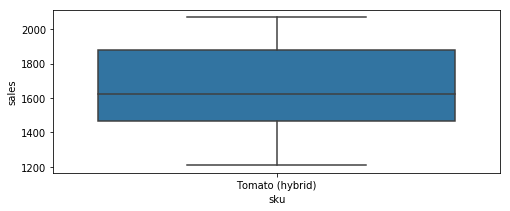

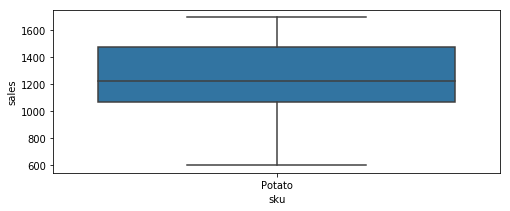

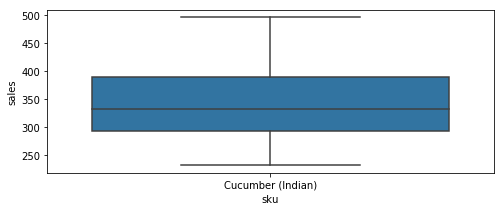

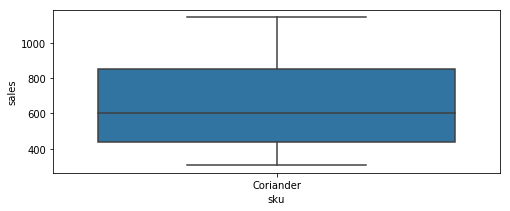

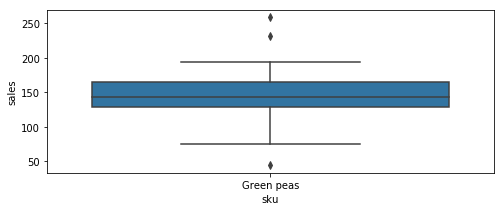

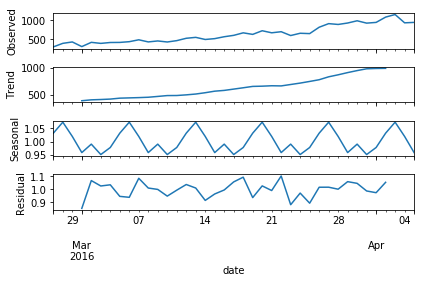

In [10]:
# EDA
for s in SKU:
    plt.figure(figsize=(8,3))
    sns.boxplot(x="sku",y="sales", data=sku_wise_data[s])
coriander = sku_wise_data['CORIANDER'].set_index('date')
result = seasonal_decompose(coriander[['sales']],model='multiplicative')
fig = result.plot()

<style>
td {
  font-size: 100px
}
</style>


# Observations
<br>
-As seen in the box plot there are outlier in the green peas sku 
<br>
-From the plot above for coriander we clearly see the seasonal component of the data, and also  the separated upward trend of the coriander sku

# Approach for Modelling

<style>
td {
  font-size: 50px
}
</style>
-To predict the features which impact the sales of the sku, random forest algorithm is used.
<br>
-The best features are selected by iteratively creating feature sets
<br>
-The sales of sku's are dependent on features such as sales_price, returns etc. 
<br>
-For coriander,time series predicton using Seasonal ARIMA model seems to perform better than Random Forest
<br>
-Seasonal ARIMA model is used to predict the sale price and mkt_price for next two days which feeds into the random forest model.
<br>
-Root Mean Squared Rrror score (RMSE) and Mean Absolute Error are used for model evaluation

# Code

In [11]:
def derived_parameter(df):
    """
    perfoms manipulation on the data frame to provide extra parameter
    returns : the data frame with extra data frame
    """
    df['lag_1_mkt_pr'] = df['mkt_pr'].shift(1)
    df.lag_1_mkt_pr.bfill(inplace=True)
    df['lag_1_diff_price'] = (df['lag_1_mkt_pr']-df['lag1_SP'])
    df['diff_price'] = (df['mkt_pr']-df['sale_price'])
    return df


In [12]:
def remove_outlier(df_in, col_name):
    """
    given the data frame removes the outlier as per quantile range 
    returns : the data frame with outlier's removed
    """
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

In [13]:
# the model to train the time series data with auto arima
def train_the_model_on_auto_arima(sku_wise_data,the_values_to_predict):
    stepwise_model = auto_arima(sku_wise_data, start_p=1, start_q=1,
                                   max_p=3, max_q=3, m=12,
                                   start_P=0, seasonal=True,
                                   d=1, D=1, trace=False,
                                   error_action='ignore',  
                                   suppress_warnings=True, 
                                   stepwise=True)
    stepwise_model.fit(sku_wise_data)
    return stepwise_model.predict(n_periods=the_values_to_predict)

In [14]:
# to predict the values of the sales and mkt_price for next two days
def future_forecast_sales_price(sku_wise_data): 
    sale_price_next_two_days={}
    mkt_price_next_two_days={}
    for s in SKU:
        sku_data=sku_wise_data[s]
        sku_sale_price = sku_data[['sale_price']]
        sku_mkt_price = sku_data[['mkt_pr']]
        
        # predict sale price
        sale_price_next_two_days[s] = train_the_model_on_auto_arima(sku_sale_price,2)
        
        # predict market price
        mkt_price_next_two_days[s] = train_the_model_on_auto_arima(sku_mkt_price,2)
        
    return sale_price_next_two_days,mkt_price_next_two_days

In [15]:
# to train the random forest model on the given features 
def train_model_on_given_feature(df,features):
    labels = np.array(df['sales'])
    features = np.array(df[features])
    train_features, test_features, train_labels, test_labels = \
        train_test_split(features, labels, test_size = 0.20, random_state = 42)
    rf = RandomForestRegressor(n_estimators = 95, random_state = 42)
    rf.fit(train_features, train_labels)
    predictions = rf.predict(test_features)
    return rf,predictions,test_labels,train_labels

In [16]:
# to calculate the error of the predicted values vs the test values 
def calculate_error(predictions,test_labels,train_labels):
    errors = abs(predictions - test_labels)
    mean_absolute_error = round(np.mean(errors), 2)
    print('Mean Absolute Error:',mean_absolute_error )
    print('Root Mean Squared Error:', round(sqrt(mean_squared_error(predictions,test_labels)),2))
    
    # checking the error of the baseline(mean)
    
    deviation_by_mean = abs(test_labels - np.mean(train_labels))
    base_mean_error = round(np.mean(deviation_by_mean), 2)
    print('Baseline Mean Absolute Error:', base_mean_error)
    print('Model performs {percent}% better than baseline' \
          .format(percent=(round((((base_mean_error-mean_absolute_error)/base_mean_error)*100),2))))
    
    

In [17]:
def train_the_model_on_different_sku_and_features():
    sku = SKU.copy()
    sku.remove('CORIANDER')
    for s in sku:
        print("Training the random forest model for {sku}".format(sku=s))
        TRAINED_MODEL[s],PREDICTION_LABELS[s],TEST_LABELS[s],TRAIN_LABELS[s] \
             = train_model_on_given_feature(sku_wise_data[s],FEATURES[s])
        print("The error in the predicted values for {sku}".format(sku=s))
        calculate_error(PREDICTION_LABELS[s],TEST_LABELS[s],TRAIN_LABELS[s])
        print()
        
    print("To predict the value using Auto ARIMA for CORIANDER".format(sku=s))
    sku_wise_corainder = sku_wise_data['CORIANDER'].set_index('date')
    TRAINED_MODEL['CORIANDER'] = sku_wise_corainder[['sales']]
    TEST_LABELS['CORIANDER']=sku_wise_corainder['2016-03-29':].sales
    TRAIN_LABELS['CORIANDER']=sku_wise_corainder[:'2016-03-28'].sales
    PREDICTION_LABELS['CORIANDER']= train_the_model_on_auto_arima(sku_wise_corainder[:'2016-03-28'].sales,8)
    print()
    print("The error in the predicted values for CORIANDER")
    calculate_error(PREDICTION_LABELS['CORIANDER'],TEST_LABELS['CORIANDER'],TRAIN_LABELS['CORIANDER'])

In [18]:
def predict_next_two_days_sales_tomato():
    # features for 06-04-2016
    lag_w1_sales_1 = float(sku_wise_data['TOMATO'][sku_wise_data['TOMATO'].date \
                                        == datetime(2016,4,6) - timedelta(days=7)].sales)
    lag_l_sp_1 = float(sku_wise_data['TOMATO'][sku_wise_data['TOMATO'].date \
                                       == datetime(2016,4,6) - timedelta(days=1)].sale_price)
    lag_1_diff_price_1 = float(sku_wise_data['TOMATO'][sku_wise_data['TOMATO'].date \
                                               == datetime(2016,4,6) - timedelta(days=1)].lag_1_diff_price) 

    # features for 07-04-2016

    lag_w1_sales_2 = float(sku_wise_data['TOMATO'][sku_wise_data['TOMATO'].date \
                                        == datetime(2016,4,7) - timedelta(days=7)].sales)
    lag_l_sp_2 = float(sale_price_next_two_days['TOMATO'][0])

    # to calculate the diff price of the forecasted sale price in mkt_price

    diff_price = sale_price_next_two_days['TOMATO'][0] - \
                                mkt_price_next_two_days['TOMATO'][0]
    lag_1_diff_price_2 = float(diff_price)


    tomato_prediction_feature = [[lag_w1_sales_1,lag_l_sp_1,lag_1_diff_price_1],
                                [lag_w1_sales_2,lag_l_sp_2,lag_1_diff_price_2]]
    return TRAINED_MODEL['TOMATO'].predict(tomato_prediction_feature)

In [19]:
def predict_next_two_days_sales_potato():
    # features for 06-04-2016
    lag_w2_sales_1 = float(sku_wise_data['POTATO'][sku_wise_data['POTATO'].date \
                                        == datetime(2016,4,6) - timedelta(days=14)].sales)
    lag_l_returns_1 = float(sku_wise_data['POTATO'][sku_wise_data['POTATO'].date \
                                       == datetime(2016,4,6) - timedelta(days=1)].returns)
    lag_day1_1 = float(sku_wise_data['TOMATO'][sku_wise_data['TOMATO'].date \
                               == datetime(2016,4,6) - timedelta(days=1)].sales)  

    #features to predict for date 06-04-2016 for potato

    potato_feature_06_04 = [lag_w2_sales_1,lag_l_returns_1,lag_day1_1]

    # features for 07-04-2016

    lag_w2_sales_2 = float(sku_wise_data['POTATO'][sku_wise_data['POTATO'].date \
                                 == datetime(2016,4,7) - timedelta(days=14)].sales)
    # we dont know what is lag_1 of and returns and it doesn't follow a trend so would take the mean of the values

    lag_l_returns_2 = np.mean(sku_wise_data['POTATO'].returns)

    # the lag of day_1 in sales would be the sales predicted for 06-04-2016

    lag_day1_2 = TRAINED_MODEL['POTATO'].predict([potato_feature_06_04])

    #features to predict for date 07-04-2016 for potato
    potato_feature_07_04 = [lag_w2_sales_2,lag_l_returns_2,lag_day1_2]
    
    return TRAINED_MODEL['POTATO'].predict([potato_feature_06_04,potato_feature_07_04])

In [20]:
def predict_next_two_days_sales_cucumber():
    # features for 06-04-2016

    lag_w2_sales_1 = float(sku_wise_data['CUCUMBER'][sku_wise_data['CUCUMBER'].date \
                                        == datetime(2016,4,6) - timedelta(days=14)].sales)

    lag_day1_1 = float(sku_wise_data['CUCUMBER'][sku_wise_data['CUCUMBER'].date \
                               == datetime(2016,4,6) - timedelta(days=1)].sales)  

    mkt_pr_1 = mkt_price_next_two_days['CUCUMBER'][0]

    #features to predict for date 06-04-2016 for cucumber

    cucumber_feature_06_04 = [lag_w2_sales_1,lag_day1_1,mkt_pr_1]

    # features for 07-04-2016

    lag_w2_sales_2 = float(sku_wise_data['CUCUMBER'][sku_wise_data['CUCUMBER'].date \
                                 == datetime(2016,4,7) - timedelta(days=14)].sales)

    # the lag of day_1 in sales would be the sales predicted for 06-04-2016

    lag_day1_2 = TRAINED_MODEL['CUCUMBER'].predict([cucumber_feature_06_04])

    mkt_pr_2 = mkt_price_next_two_days['CUCUMBER'][1]

    #features to predict for date 07-04-2016 for potato
    cucumber_feature_07_04 = [lag_w2_sales_2,lag_day1_2,mkt_pr_2]
    
    return TRAINED_MODEL['CUCUMBER'].predict([cucumber_feature_06_04,cucumber_feature_07_04])

In [21]:
def predict_next_two_days_sales_green_peas():
    
    # features for 06-04-2016

    lag_l_returns_1 = float(sku_wise_data['GREEN_PEAS'][sku_wise_data['GREEN_PEAS'].date \
                                           == datetime(2016,4,6) - timedelta(days=1)].returns)

    sale_price_1 = sale_price_next_two_days['GREEN_PEAS'][0]

    lag1_SP_1 = float(sku_wise_data['GREEN_PEAS'][sku_wise_data['GREEN_PEAS'].date \
                               == datetime(2016,4,6) - timedelta(days=1)].sale_price) 

    lag_day1_1 = float(sku_wise_data['GREEN_PEAS'][sku_wise_data['GREEN_PEAS'].date \
                               == datetime(2016,4,6) - timedelta(days=1)].sales)

    #features to predict for date 06-04-2016 for cucumber

    green_peas_feature_06_04 = [lag_l_returns_1,sale_price_1,lag1_SP_1,lag_day1_1]

    # features for 07-04-2016

    # we dont know what is lag_1 of and returns and it doesn't follow a trend so would take the mean of the values
    lag_l_returns_2 = np.mean(sku_wise_data['GREEN_PEAS'].returns)

    sale_price_2 = sale_price_next_two_days['GREEN_PEAS'][1]

    lag1_SP_2 = sale_price_next_two_days['GREEN_PEAS'][0]

    lag_day1_2 = TRAINED_MODEL['GREEN_PEAS'].predict([green_peas_feature_06_04])

    green_peas_feature_07_04 = [lag_l_returns_2,sale_price_2,lag1_SP_2,lag_day1_2]

    return TRAINED_MODEL['GREEN_PEAS'].predict([green_peas_feature_06_04,green_peas_feature_07_04])

In [22]:
def predict_next_two_days_sales_coriander():
    print("To predict the value using Auto ARIMA for CORIANDER")
    sku_wise_corainder = sku_wise_data['CORIANDER'].set_index('date')
    return train_the_model_on_auto_arima(sku_wise_corainder.sales,2)
    

In [23]:
#derive some extra features such as lag_1_mkt_pr,lag_1_diff_price_etc
#remove outlier in the data frame(are observed in green peas)
for s in SKU:
    sku_wise_data[s]= derived_parameter(sku_wise_data[s])
    sku_wise_data[s]= remove_outlier(sku_wise_data[s],'sales')

In [24]:
# to predict the sale price and mkt_price for next two days using seasonal arima Model
sale_price_next_two_days,mkt_price_next_two_days = \
            future_forecast_sales_price(sku_wise_data)

In [25]:
# to train and display error on different sku data
train_the_model_on_different_sku_and_features()

Training the random forest model for TOMATO
The error in the predicted values for TOMATO
Mean Absolute Error: 80.67
Root Mean Squared Error: 104.34
Baseline Mean Absolute Error: 115.93
Model performs 30.41% better than baseline

Training the random forest model for POTATO
The error in the predicted values for POTATO
Mean Absolute Error: 86.66
Root Mean Squared Error: 101.93
Baseline Mean Absolute Error: 141.11
Model performs 38.59% better than baseline

Training the random forest model for CUCUMBER
The error in the predicted values for CUCUMBER
Mean Absolute Error: 63.86
Root Mean Squared Error: 75.77
Baseline Mean Absolute Error: 70.21
Model performs 9.04% better than baseline

Training the random forest model for GREEN_PEAS
The error in the predicted values for GREEN_PEAS
Mean Absolute Error: 10.15
Root Mean Squared Error: 13.85
Baseline Mean Absolute Error: 17.0
Model performs 40.29% better than baseline

To predict the value using Auto ARIMA for CORIANDER

The error in the predicte

In [26]:
predict_next_two_days_sales_tomato()

array([1500.        , 1426.08421053])

In [27]:
predict_next_two_days_sales_potato()

array([1191.83157895, 1331.95789474])

In [28]:
predict_next_two_days_sales_cucumber()

array([319.77894737, 346.91578947])

In [29]:
predict_next_two_days_sales_green_peas()

array([117.10526316, 121.14736842])

In [30]:
predict_next_two_days_sales_coriander()

To predict the value using Auto ARIMA for CORIANDER


array([1018.46436378, 1193.43858331])